In [1]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Load the data
df = pd.read_csv('hyderabad.csv')  

In [2]:
df=df[['date_time','humidity','pressure','tempC']]
df.head()

,date_time,humidity,pressure,tempC
0,2009-01-01 00:00:00,83,1013,16
1,2009-01-01 01:00:00,85,1013,16
2,2009-01-01 02:00:00,86,1013,15
3,2009-01-01 03:00:00,88,1013,15
4,2009-01-01 04:00:00,80,1014,16


In [4]:
uni_data = df['tempC']
uni_data.index = df['date_time']
uni_data.head()

date_time
2009-01-01 00:00:00    16
2009-01-01 01:00:00    16
2009-01-01 02:00:00    15
2009-01-01 03:00:00    15
2009-01-01 04:00:00    16
Name: tempC, dtype: int64

In [5]:
TRAIN_SPLIT=87672
uni_train_mean = uni_data.mean()
uni_train_std = uni_data.std()
uni_data = (uni_data-uni_train_mean)/uni_train_std
uni_data=uni_data.values

In [6]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i + target_size])
    return np.array(data), np.array(labels)


univariate_past_history = 6
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT, univariate_past_history, univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None, univariate_past_history, univariate_future_target)


In [7]:
def create_time_steps(length):
  return list(range(-length, 0))
def show_plot(plot_data, delta, title, time_steps=1):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            time_steps = create_time_steps(plot_data[i].shape[0]) * time_steps
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlabel('Time-Step')
    return plt
#show_plot([x_train_uni[12], y_train_uni[12]], 0, 'Sample Example')


In [8]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

# Create TensorFlow datasets
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

tf.keras.backend.clear_session()

complex_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.LSTM(16, return_sequences=True),
    tf.keras.layers.LSTM(8),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

complex_lstm_model.compile(optimizer='adam', loss='mae')
complex_lstm_model.summary()


from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
complex_lstm_model, to_file='model.png', show_shapes=False, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 32)             4352      
                                                                 
 lstm_1 (LSTM)               (None, 6, 16)             3136      
                                                                 
 lstm_2 (LSTM)               (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8,449
Trainable params: 8,449
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and insta

In [9]:
for x, y in val_univariate.take(1):
    print(complex_lstm_model.predict(x).shape)
EVALUATION_INTERVAL = 200
EPOCHS = 20
history_complex = complex_lstm_model.fit(train_univariate, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_univariate, validation_steps=50)


8/8 [==============================] - 3s 6ms/step
(256, 1)
Epoch 1/20
200/200 [==============================] - 22s 42ms/step - loss: 0.4541 - val_loss: 0.1328
Epoch 2/20
200/200 [==============================] - 5s 27ms/step - loss: 0.1165 - val_loss: 0.1205
Epoch 3/20
200/200 [==============================] - 5s 26ms/step - loss: 0.1115 - val_loss: 0.1030
Epoch 4/20
200/200 [==============================] - 5s 25ms/step - loss: 0.1126 - val_loss: 0.1024
Epoch 5/20
200/200 [==============================] - 5s 25ms/step - loss: 0.1075 - val_loss: 0.1030
Epoch 6/20
200/200 [==============================] - 5s 26ms/step - loss: 0.1123 - val_loss: 0.1055
Epoch 7/20
200/200 [==============================] - 5s 25ms/step - loss: 0.1076 - val_loss: 0.1058
Epoch 8/20
200/200 [==============================] - 5s 26ms/step - loss: 0.1104 - val_loss: 0.1148
Epoch 9/20
200/200 [==============================] - 5s 26ms/step - loss: 0.1092 - val_loss: 0.1052
Epoch 10/20
200/200 [=========

In [10]:
def generate_predictions(model, x_data):
    predictions = model.predict(x_data)
    return predictions[:, 0]
def evaluate_predictions(y_true, y_pred):
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse,rmse, mae,mape

# Time durations
durations = [24 ,24 * 30, 24 * 30 * 6, len(x_val_uni)]



1/1 [==============================] - 3s 3s/step


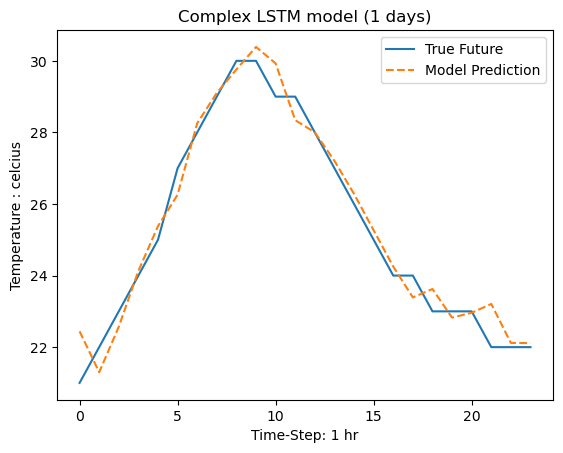

Evaluation Metrics for 1 days:
Mean Squared Error (MSE): 0.3156707041372708
Root Mean Squared Error (RMSE): 0.5618458010319831
Mean Absolute Error (MAE): 0.4287351767222087
Mean Absolute Percentage Error (MAPE): 1.7601589144681744%
------------------------------------------
23/23 [==============================] - 0s 6ms/step


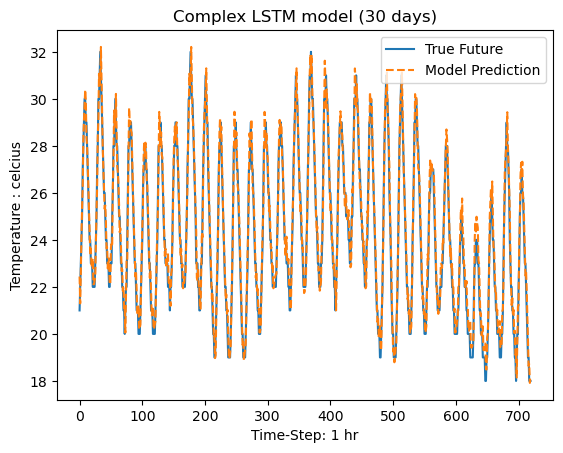

Evaluation Metrics for 30 days:
Mean Squared Error (MSE): 0.41617838773777294
Root Mean Squared Error (RMSE): 0.6451188942650594
Mean Absolute Error (MAE): 0.5199869500266181
Mean Absolute Percentage Error (MAPE): 2.1636423336011257%
------------------------------------------
135/135 [==============================] - 1s 6ms/step


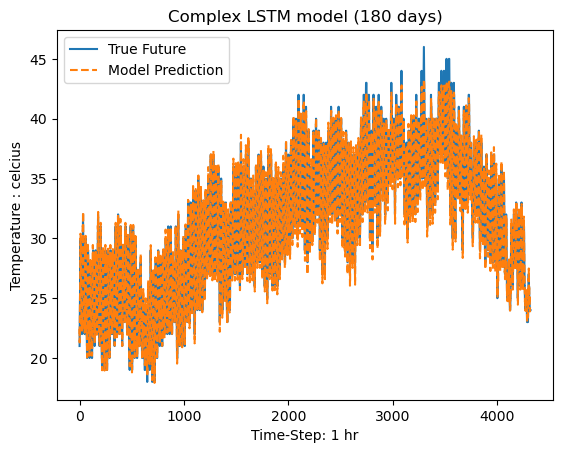

Evaluation Metrics for 180 days:
Mean Squared Error (MSE): 0.4725501438356096
Root Mean Squared Error (RMSE): 0.6874228275491072
Mean Absolute Error (MAE): 0.5463147834495262
Mean Absolute Percentage Error (MAPE): 1.7743547567539024%
------------------------------------------
274/274 [==============================] - 2s 6ms/step


C:\Users\arjun\AppData\Local\Temp\ipykernel_20164\4145625938.py:8: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


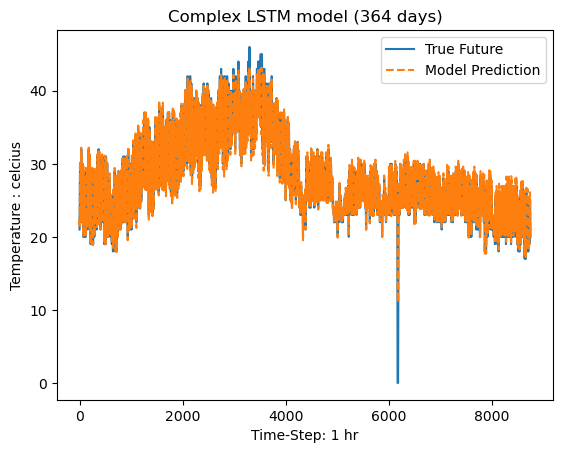

Evaluation Metrics for 364 days:
Mean Squared Error (MSE): 0.643360509945624
Root Mean Squared Error (RMSE): 0.8020975688441051
Mean Absolute Error (MAE): 0.5313472095242858
Mean Absolute Percentage Error (MAPE): inf%
------------------------------------------


In [11]:
for duration in durations:
    x_val_duration, y_val_duration = x_val_uni[:duration], y_val_uni[:duration]

    predictions_duration = generate_predictions(complex_lstm_model, x_val_duration)

    # Inverse normalize the data and predictions
    y_val_duration_original = y_val_duration * uni_train_std + uni_train_mean
    predictions_duration_original = predictions_duration * uni_train_std + uni_train_mean

    # Evaluate predictions
    mse, rmse, mae, mape = evaluate_predictions(y_val_duration_original, predictions_duration_original)

    # Plotting
    plt.plot(y_val_duration_original, label='True Future')
    plt.plot(predictions_duration_original, label='Model Prediction', linestyle='dashed')
    plt.title(f'Complex LSTM model ({duration//24} days)')
    plt.xlabel('Time-Step: 1 hr')
    plt.ylabel('Temperature : celcius')
    plt.legend()
    plt.show()

    # Print evaluation metrics
    print(f'Evaluation Metrics for {duration//24} days:')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
    print('------------------------------------------')
